# Image Classification

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/cifar/cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [01:59, 1.43MB/s]                               


All files found!


## Explore the Data
The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Below, we can explore the dataset


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


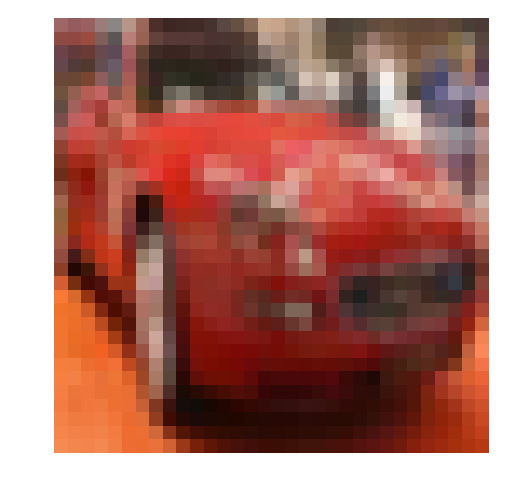

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize


In [14]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x / 255

### One-hot encoding labels

In [15]:
def one_hot_encode(x):
    from sklearn.preprocessing import label_binarize
    x = label_binarize(x,classes=[0,1,2,3,4,5,6,7,8,9])
    """
    One hot encode a list of sample labels. Returns a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    return x

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [13]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is our first checkpoint.The preprocessed data has been saved to disk.

In [16]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. The following functions are implemented.
* `neural_net_image_input`
 * Returns a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Sets the shape using `image_shape` with batch size set to `None`.
 * TensorFlow placeholder is named "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
*  `neural_net_label_input`
 * Returns a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Sets the shape using `n_classes` with batch size set to `None`.
 * TensorFlow placeholder is named "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * TensorFlow placeholder is named "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load our saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [17]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    x = tf.placeholder(tf.float32,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name='x')
    return x


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    y = tf.placeholder(tf.int32,shape=(None,n_classes),name='y')
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    kp = tf.placeholder(tf.float32,name='keep_prob')
    return kp


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. `conv2d_maxpool`  function is implemented to apply convolution then max pooling with the following steps:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.

In [18]:
MEAN_INIT = 0.001
STDDEV_INIT = 0.05
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    x_batch, x_height, x_width, x_depth = x_tensor.shape
    F_W = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT,shape=[*conv_ksize,
                                                                                    x_depth.value,conv_num_outputs]))
    F_B = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT,shape=[conv_num_outputs]))
    layer = tf.nn.conv2d(x_tensor,F_W,
                         strides = [1, conv_strides[0], conv_strides[1], 1] ,padding='SAME' )
    layer = tf.nn.bias_add(layer,F_B)
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1,pool_ksize[0],pool_ksize[1],1], 
                           strides=[1,pool_strides[0],pool_strides[1],1],padding='SAME')
    
    return layer


### Flatten Layer

In [19]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    shape = x_tensor.get_shape().as_list() 
    x_tensor = tf.reshape(x_tensor,[-1,shape[1]*shape[2]*shape[3]])
    return x_tensor

### Fully-Connected Layer

In [20]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weights = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, 
                                              shape=[x_tensor.shape[1].value, num_outputs]))
    bias = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, shape=[num_outputs]))
    return tf.nn.relu(tf.add(tf.matmul(x_tensor, weights), bias))


### Output Layer

In [21]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weights = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, 
                                              shape=[x_tensor.shape[1].value, num_outputs]))
    bias = tf.Variable(tf.truncated_normal(mean=MEAN_INIT, stddev=STDDEV_INIT, shape=[num_outputs]))
    return tf.add(tf.matmul(x_tensor, weights), bias)


### Create Convolutional Model

In [22]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    x = conv2d_maxpool(x, 16, (5, 5), (1, 1), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 32, (5, 5), (1, 1), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 64, (5, 5), (1, 1), (2, 2), (2, 2))
    
    x = flatten(x)
    

    x = fully_conn(x, num_outputs=786)
    x = fully_conn(x, num_outputs=786)
    x = tf.nn.dropout(x, keep_prob)
    
    x = output(x, num_outputs=10)
    
    return x

## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [23]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    feed_dict = {'keep_prob:0': keep_probability, 'x:0': feature_batch, 'y:0': label_batch}
    session.run(optimizer, feed_dict=feed_dict)

### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [24]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    feed_cost = {'keep_prob:0': 1.0, 'x:0': feature_batch, 'y:0': label_batch}
    feed_valid = {'keep_prob:0': 1.0, 'x:0': valid_features, 'y:0': valid_labels}
    cost = session.run(cost, feed_dict=feed_cost)
    accuracy = session.run(accuracy, feed_dict=feed_valid)
    print("cost: {}, accuracy: {}".format(cost, accuracy))

### Hyperparameters
* `epochs` are number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* `keep_probability` is the probability of keeping a node using dropout

In [25]:
epochs = 10
batch_size = 128
keep_probability = 0.8

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's first use a single batch.

In [26]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  cost: 2.0413920879364014, accuracy: 0.2924000024795532
Epoch  2, CIFAR-10 Batch 1:  cost: 1.8609392642974854, accuracy: 0.3885999917984009
Epoch  3, CIFAR-10 Batch 1:  cost: 1.7381279468536377, accuracy: 0.42500001192092896
Epoch  4, CIFAR-10 Batch 1:  cost: 1.4713393449783325, accuracy: 0.4729999899864197
Epoch  5, CIFAR-10 Batch 1:  cost: 1.185044288635254, accuracy: 0.5112000107765198
Epoch  6, CIFAR-10 Batch 1:  cost: 0.9752483367919922, accuracy: 0.5094000101089478
Epoch  7, CIFAR-10 Batch 1:  cost: 0.8572978973388672, accuracy: 0.5188000202178955
Epoch  8, CIFAR-10 Batch 1:  cost: 0.7300836443901062, accuracy: 0.5483999848365784
Epoch  9, CIFAR-10 Batch 1:  cost: 0.5330621004104614, accuracy: 0.5400000214576721
Epoch 10, CIFAR-10 Batch 1:  cost: 0.46701645851135254, accuracy: 0.5008000135421753


### Fully Train the Model
Now try it with all five batches.

In [27]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  cost: 2.053872585296631, accuracy: 0.33160001039505005
Epoch  1, CIFAR-10 Batch 2:  cost: 1.6640905141830444, accuracy: 0.4106000065803528
Epoch  1, CIFAR-10 Batch 3:  cost: 1.2075238227844238, accuracy: 0.4551999866962433
Epoch  1, CIFAR-10 Batch 4:  cost: 1.332988977432251, accuracy: 0.5037999749183655
Epoch  1, CIFAR-10 Batch 5:  cost: 1.3519515991210938, accuracy: 0.5397999882698059
Epoch  2, CIFAR-10 Batch 1:  cost: 1.38324773311615, accuracy: 0.5388000011444092
Epoch  2, CIFAR-10 Batch 2:  cost: 1.0540517568588257, accuracy: 0.5515999794006348
Epoch  2, CIFAR-10 Batch 3:  cost: 0.7780689001083374, accuracy: 0.5734000205993652
Epoch  2, CIFAR-10 Batch 4:  cost: 0.9809819459915161, accuracy: 0.5852000117301941
Epoch  2, CIFAR-10 Batch 5:  cost: 0.8761410713195801, accuracy: 0.6039999723434448
Epoch  3, CIFAR-10 Batch 1:  cost: 0.9823465347290039, accuracy: 0.5914000272750854
Epoch  3, CIFAR-10 Batch 2:  cost: 0.7964011430740356, accuracy: 0.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6403283227848101



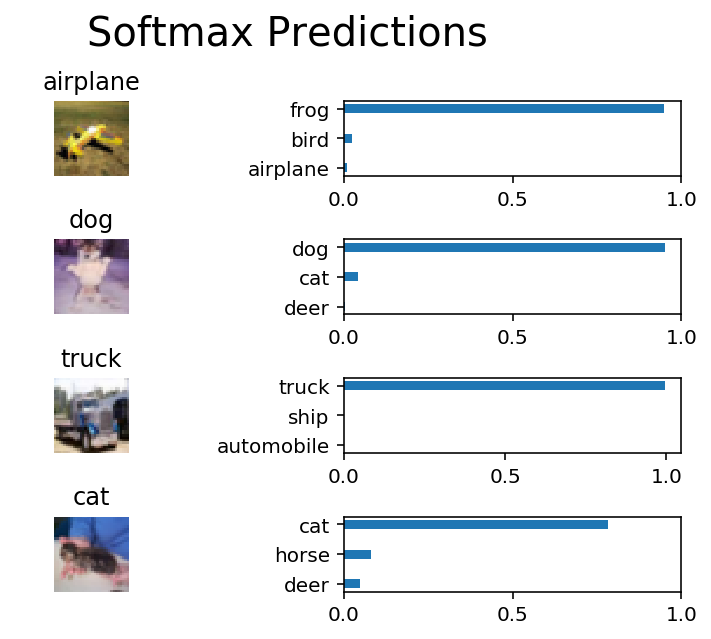

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()